# Keywords matching and relevance index ranking 

In [1]:
# import packages
import pandas as pd
import numpy as np
import math
from nltk import ngrams
from matplotlib import pyplot as plt
import os
import seaborn as sns
from nltk.tokenize import word_tokenize
import re

In [2]:
# import internal modules
import file_path_management as fpath
import public_library as plib
import parameters as params
import dataframe_columns as df_col

2023-11-27 17:42:37 GM01X680 metapub.config[170388] WARNING NCBI_API_KEY was not set.


## Predefined fucntions:

In [3]:
def transform(count):
    # transform the count
    return math.log(1 + count)
# # --------------------start of test code--------------------
# elem = 0
# print(transform(10))
# # ---------------------end of test code---------------------

In [4]:
def not_TT(index: int):
    text_path = os.path.join(fpath.text_folder, str(index) + ".txt")
    
    if os.path.exists(text_path):
        with open(text_path, 'r', encoding="ascii") as f:
            text = f.read()
        
        text = plib.process_text(text, lower=True)
    
        if len(text.split()) >= 4000 and ("inject" not in text):
            return True
        else:
            return False
    else:
        return False
# # --------------------start of test code--------------------
# index = 72
# if_not_TT(index)
# # ---------------------end of test code---------------------

In [5]:
def get_title_ta(ind):
    df_db = pd.read_csv(fpath.poten_litera_db, header=0, sep="\t")
    
    ta = ""
    
    title = df_db.at[ind, "TITLE"]
    abstract = df_db.at[ind, "ABSTRACT"]
    # keywords = df_db.at[ind, "KEYWORDS"]
    
    if title != title:
        title = ""
    
    if abstract != abstract:
        abstract = ""
        
    # if keywords != keywords:
    #     keywords = ""
    
    # if abstract is empty, then ta is empty
    if abstract != abstract or abstract == "":
        ta = ""
    else:
        ta = title + " " + abstract
    
    # process title and ta
    title = plib.process_text(title, lower=True)
    ta = plib.process_text(ta, lower=True)
        
    return title, ta
# # --------------------start of test code--------------------
# ind = 1
# title, ta = get_ta(ind)
# print title
# print ta
# # ---------------------end of test code---------------------

In [6]:
def keyword_in_text(keyword, text):
    # process keyword and text
    keyword = plib.process_text(keyword, lower=True)
    text = plib.process_text(text, lower=True)
    
    # if keyword is in exact match keyword list
    if keyword in params.exact_match_kw_list:
        # length of the keyword
        len_word = len(keyword.split())
        
        # word tokenization
        tokens = word_tokenize(text)
        
        # get the ngrams of length len_word from text
        ng = list(ngrams(tokens, len_word))
        words = [' '.join(gram) for gram in ng]
        # print(words)

        for w in words:
            if keyword == w:
                return True
    # if keyword is not in exact match keyword list
    else:
        if keyword in text:
            return True
    
    return False
# # --------------------start of test code--------------------
# keyword = "new world titi monkey"
# text = "There cat new new world titi monkeyworld monkey rodent is an owl monkey, a spider monkey, some howler monkeys, and then just a monkey playing around."
# if_keyword_in_text(keyword, text)
# # ---------------------end of test code---------------------

In [7]:
def remove_keywords_from_text(text, keywords):
    # Iterate until no keywords are found in the text
    while any(re.search(r'\b' + re.escape(keyword) + r's?\b', text, re.IGNORECASE) for keyword in keywords):
        for keyword in keywords:
            # Use regular expression to remove both singular and plural forms of the keyword
            text = re.sub(r'\b' + re.escape(keyword) + r's?\b', '', text, flags=re.IGNORECASE)

            # Remove extra spaces left after removal
            text = re.sub(r'\s+', ' ', text).strip()

    return text
# # --------------------start of test code--------------------
# # Example text
# text = "There is an owl monkeys, a macaque monkeys, and a capuchin monkey in the zoos. 'cat', 'cats', 'rat', 'rats', 'mouse', 'mice', 'marmoset monkey', 'marmoset', 'human', 'humans', 'man', 'men', 'dog', 'dogs', 'rabbit', 'sheep', 'frog', 'frogs', 'squirrel monkey', 'saimiri sciureus', 'hedgehog', 'erinaceus europaeus', 'callithrix jacchus', 'hamster', 'phodopus sungorus', 'pig', 'pigs', 'minipig', 'cavia aperta', 'wallaby', 'macropus eugenii', 'bat', 'bats', 'otolemur garnetti', 'new world titi monkey', 'callicebus moloch', 'owl monkey', 'aotus trivirgatus', 'new world monkey', 'ferret', 'ferrets', 'bush baby', 'galago', 'galagos', 'rodent', 'rodents', 'cebus apella', 'cebus monkey', 'chicken', 'possum', 'trichosurus vulpecula', 'prosimian', 'antrozous pallidus', 'shrew', 'shrews', 'suncus murinus', 'gerbil', 'gerbils', 'swine', 'swines',"

# # List of keywords to remove
# keywords = params.other_spiecies_group

# # Remove keywords from the text
# updated_text = remove_keywords_from_text(text, keywords)

# print(updated_text)
# # ---------------------end of test code---------------------

In [8]:
def not_macaque_but_others(ta):
    # return True if the text is not about macaque but other species
    # return False for other cases
    
    # if ta is empty
    if ta == "":
        return False
    
    # process text
    ta = plib.process_text(ta, lower=True)
    
    macaque_label = False
    other_species_label = False
     
    # other species   
    for keyword in params.other_spiecies_group:
        if keyword_in_text(keyword, ta):
            other_species_label = True
    
    text = remove_keywords_from_text(ta, params.other_spiecies_group)
    # print(text)
    
    # macaque
    for word in params.possible_macaque_group:
        if keyword_in_text(word, text):
            macaque_label = True
    
    if (not macaque_label) and other_species_label:
        return True
    else:
        return False
# # --------------------start of test code--------------------
# ta = "The  different squirrel monkeys prefrontal cortical regions exert executive control over processing occurring in posterior cortical regions. We examined with the autoradiographic method, in the, the course and terminations of the efferent corticocortical connections of the rostral prefrontal region, the function of which is least understood. Three efferent streams of fibers organized into three distinct fasciculi convey rostral prefrontal influences on posterior cortical areas. These connections provide powerful insights into the cortical regions on which executive control is being exercised. The lateral stream of fibers via the extreme capsule targets the midsection of the auditory superior temporal region and the multisensory areas of the superior temporal sulcus, thus permitting control over the most integrated aspects of cognitive processing. The fibers coursing through the extreme capsule originating in areas 10 and 9 continue as part of the white matter of the superior temporal gyrus (i.e., the middle longitudinal fasciculus) to target the midportion of the superior temporal gyrus (areas TAa, TS2, and TS3) and adjacent multisensory area TPO within the upper bank of the superior temporal sulcus. Some of the fibers from areas 10 and 9 that enter the extreme capsule terminate in the ventral part of the insula. The dorsomedial limbic stream via the cingulate fasciculus targets the anterior and posterior cingulate cortex, as well as the retrosplenial cortex, allowing control over motivational and memory processes. A ventral limbic stream via the uncinate fasciculus targets the temporal proisocortex and the amygdala, indicating an additional powerful influence over the emotional motivational sphere."
# not_macaque_but_others(ta)
# # ---------------------end of test code---------------------

In [9]:
def relevance_index(not_TT, not_macaque_but_others, count_dict):
    relevance_index = 0
    
    for key in count_dict.keys():
        relevance_index += transform(count_dict[key]) * (params.ranking_kw_groups_weights[key])
    
    if not_TT == "Y" or not_macaque_but_others == "Y":
        relevance_index = 0.1 * relevance_index
        
    return relevance_index
# --------------------start of test code--------------------
# keywords_count_or_fre = {}
# index = calcul_related(keywords_count_or_fre, params.on_topic_kws_weights)
# print(index)
# ---------------------end of test code---------------------

In [10]:
def compute_relevance_index(db_count_path, db_relevance_index_path, rank_by):
    df = pd.read_csv(db_count_path, header=0, sep="\t")
    
    if rank_by == 'ta':
        column_name = '_COUNT_IN_TA'
    elif rank_by == '500':
        column_name = '_COUNT_IN_500'
    elif rank_by == 'full_text':
        column_name = '_COUNT_IN_FULL_TEXT'
        
    count_dict = {}
    
    for ind in df.index:
        # index = int(df.at[ind, "INDEX"])
        
        not_TT = df.at[ind, "NOT_TT"]
        not_macaque_but_others = df.at[ind, "NOT_MACAQUE_BUT_OTHERS"] 
        
        for key in params.ranking_kw_groups.keys():
            # if key == 'INJECT' or 'METHOD':
            #     value = df.at[ind, key+'_COUNT_IN_FULL_TEXT']
            # else:
            #     value = df.at[ind, key+column_name]
            value = df.at[ind, key+column_name]
            
            if value != value:
                value = 0
                
            count_dict[key] = int(value)
        # print(count_dict)
        
        relev_index = relevance_index(not_TT, not_macaque_but_others, count_dict)
        
        df.at[ind, "RELEVANCE_INDEX"] = relev_index

        line_number_in_csv = ind + 1
        print("Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))
    
    df.columns = df_col.db_ranked_columns
    df.reset_index(drop=True, inplace=True)
    df.to_csv(db_relevance_index_path, header=True, index=False, sep="\t")
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_db_kw_count
# output_path = fpath.poten_litera_db_ranked
# rank(input_path, output_path, params.ranking_params_weights)
# ---------------------end of test code---------------------

In [11]:
def rank_and_save(input_path, output_path):
    plib.clear_file(output_path)
    
    # sort
    df_to_rank = pd.read_csv(input_path, header=0, sep="\t")

    # sort by relevance index
    df_to_rank.sort_values(by=['RELEVANCE_INDEX'], ascending=False, inplace=True)
        
    df_to_rank.reset_index(drop=True, inplace=True)
    
    df_to_rank.to_csv(output_path, header=True, index=False, sep="\t")

## Main program:

In [12]:
# # Add columns of "NOT_TT" and "NOT_MACAQUE_BUT_OTHER"
# input_path = fpath.poten_litera_db_kw_count
# df = pd.read_csv(input_path, header=0, sep="\t")

# output_path = fpath.poten_litera_db_kw_count_with_2_new_columns
# plib.clear_file(output_path)

# for ind in df.index:
#     index = int(df.at[ind, "INDEX"])
    
#     title, ta = get_title_ta(ind)
    
#     if not_TT(index):
#         df.at[ind, "NOT_TT"] = "Y"
    
#     if not_macaque_but_others(ta):
#         df.at[ind, "NOT_MACAQUE_BUT_OTHERS"] = "Y"

#     line_number_in_csv = ind + 1
#     print("Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))
    
# df.columns = df_col.db_ranked_columns_with_2_new_columns
# df.reset_index(drop=True, inplace=True)
# df.to_csv(output_path, header=True, index=False, sep="\t")

### 1. Calculate relevance index and rank

In [13]:
rank_by = 'ta'
# rank_by = '500'
# rank_by = 'full_text'

In [14]:
# compute relevance index and rank
input_path = fpath.poten_litera_db_kw_count_with_2_new_columns
relevance_index_path = fpath.poten_litera_db_relevance_index
plib.clear_file(relevance_index_path)

# compute relevance index
compute_relevance_index(input_path, relevance_index_path, rank_by)

# rank
if rank_by == 'ta':
    # rank by ta    
    rank_and_save(relevance_index_path, fpath.poten_litera_db_ranked_by_ta)
elif rank_by == '500':
    # rank by 500    
    rank_and_save(relevance_index_path, fpath.poten_litera_db_ranked_by_500)
elif rank_by == 'full_text':
    # rank by full text
    rank_and_save(relevance_index_path, fpath.poten_litera_db_ranked_by_full_text)

Line number: 1  INDEX: 0
Line number: 2  INDEX: 1
Line number: 3  INDEX: 2
Line number: 4  INDEX: 4
Line number: 5  INDEX: 5
Line number: 6  INDEX: 6
Line number: 7  INDEX: 7
Line number: 8  INDEX: 8
Line number: 9  INDEX: 9
Line number: 10  INDEX: 10
Line number: 11  INDEX: 11
Line number: 12  INDEX: 12
Line number: 13  INDEX: 13
Line number: 14  INDEX: 14
Line number: 15  INDEX: 15
Line number: 16  INDEX: 16
Line number: 17  INDEX: 17
Line number: 18  INDEX: 18
Line number: 19  INDEX: 19
Line number: 20  INDEX: 20
Line number: 21  INDEX: 21
Line number: 22  INDEX: 22
Line number: 23  INDEX: 23
Line number: 24  INDEX: 24
Line number: 25  INDEX: 25
Line number: 26  INDEX: 26
Line number: 27  INDEX: 27
Line number: 28  INDEX: 28
Line number: 29  INDEX: 29
Line number: 30  INDEX: 30
Line number: 31  INDEX: 31
Line number: 32  INDEX: 32
Line number: 33  INDEX: 33
Line number: 34  INDEX: 34
Line number: 35  INDEX: 35
Line number: 36  INDEX: 36
Line number: 37  INDEX: 37
Line number: 38  IN

### 2. Ranking results analysis

In [15]:
# initialize lists

# relevant group
R_species = []
R_other_species = []
R_tc_ct = []
R_thalam = []
R_cortex = []
R_inject = []
R_method = []
R_connectivity = []

# index list of the relevant group
R_index_list = []
# relevance index list of the relevant group
R_relevance_index_list = []

R_review_index_list = []

# Irrelevant group
IR_species = []
IR_other_species = []
IR_tc_ct = []
IR_thalam = []
IR_cortex = []
IR_inject = []
IR_method = []
IR_connectivity = []

# index list of the irrelevant group
IR_index_list = []
# relevance index list of the irrelevant group
IR_relevance_index_list = []

In [16]:
# choose the df_db_ranked based on the rank_by
if rank_by == 'ta':
    # rank by ta
    df_db_ranked = pd.read_csv(fpath.poten_litera_db_ranked_by_ta, header=0, sep='\t')
    column_name_base = "TA"
# elif rank_by == '500':
#     # rank by 500
#     df_db_ranked = pd.read_csv(fpath.poten_litera_db_ranked_by_500, header=0, sep='\t')
#     column_name_base = "500"
# elif rank_by == 'full_text':
#     # rank by full_text
#     df_db_ranked = pd.read_csv(fpath.poten_litera_db_ranked_by_full_text, header=0, sep='\t')
#     column_name_base = "FULL_TEXT"

In [17]:
# record the final_manually_read_csv_1_labeled

# read the labeled testing set
df = pd.read_csv(fpath.final_manually_read_csv_1_labeled, header=0, sep='\t')

for ind in df.index:
    index = int(df.at[ind, "INDEX"])
    
    if (index in R_index_list) or (index in IR_index_list) or (index in R_review_index_list):
        continue
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y" and df.at[ind, "REVIEW(Y/N)"] == "Y":
        R_review_index_list.append(index)
        
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y" and df.at[ind, "REVIEW(Y/N)"] != "Y":
        R_index_list.append(index)
        R_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        R_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        R_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        R_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        R_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        R_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        R_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        R_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        R_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "N":
        IR_index_list.append(index)
        IR_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        IR_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        IR_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        IR_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        IR_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        IR_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        IR_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        IR_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        IR_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])

In [18]:
print(R_index_list)
print(R_review_index_list)
print(IR_index_list)

[321, 142, 120, 329, 1001, 2459, 42, 2772, 1075, 89, 53, 242, 76, 11, 923, 182, 147, 903, 191, 151, 20, 96, 636, 374, 901, 2567, 143, 380, 1147, 232, 185, 194, 2418, 228, 39, 7, 758, 218, 509, 23, 82, 911, 1602, 29, 92, 349, 17, 127, 1385, 2945, 81, 95, 264, 957, 41, 128, 425, 115, 27, 103, 100, 2703, 33, 1363, 340, 1284, 114, 546, 4, 330, 820, 476, 941, 313, 428]
[377, 310, 416, 220, 276]
[900, 592, 969, 1252, 630, 773, 2645, 277, 254, 2165, 909, 395, 126, 926, 1112, 855, 917, 1031, 904, 531, 975, 4010, 1193, 4668, 459, 1134, 1106, 945, 952, 5672, 910, 586, 2535, 1125, 57, 1581, 1072, 867, 438, 4660, 942, 3977, 4957, 5488, 517, 1189, 2421, 949, 5544, 965, 967, 196, 1088, 905, 929, 608, 4882, 637, 1059, 4039, 442, 2521, 1126, 777, 868, 4378, 97, 3908, 1246, 878, 1629, 1314, 751, 4457, 643, 1135, 1108, 631, 1173, 5877, 1131, 1524, 978, 171, 5114, 4242, 785, 4545, 4057, 1334, 1039, 2428, 2831, 1313, 4233, 740, 979, 960, 1165, 4101, 4652, 5239, 1341, 946, 626, 4178, 1019, 501, 1702, 1535,

In [19]:
# record the final_manually_read_csv_2_labeled

# read the labeled testing set
df = pd.read_csv(fpath.final_manually_read_csv_2_labeled, header=0, sep='\t')

for ind in df.index:
    index = int(df.at[ind, "INDEX"])

    if (index in R_index_list) or (index in IR_index_list) or (index in R_review_index_list):
        continue
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y" and df.at[ind, "REVIEW(Y/N)"] == "Y":
        R_review_index_list.append(index)
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y" and df.at[ind, "REVIEW(Y/N)"] != "Y":
        R_index_list.append(index)
        R_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        R_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        R_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        R_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        R_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        R_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        R_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        R_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        R_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "N":
        IR_index_list.append(index)
        IR_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        IR_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        IR_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        IR_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        IR_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        IR_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        IR_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        IR_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        IR_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])

In [20]:
print(R_index_list)
print(R_review_index_list)
print(IR_index_list)

[321, 142, 120, 329, 1001, 2459, 42, 2772, 1075, 89, 53, 242, 76, 11, 923, 182, 147, 903, 191, 151, 20, 96, 636, 374, 901, 2567, 143, 380, 1147, 232, 185, 194, 2418, 228, 39, 7, 758, 218, 509, 23, 82, 911, 1602, 29, 92, 349, 17, 127, 1385, 2945, 81, 95, 264, 957, 41, 128, 425, 115, 27, 103, 100, 2703, 33, 1363, 340, 1284, 114, 546, 4, 330, 820, 476, 941, 313, 428, 3153, 2678, 37, 3044, 390, 1509, 470, 272, 6848, 3126, 256, 974, 2525, 467, 730, 326, 296, 206, 4063, 784, 3625]
[377, 310, 416, 220, 276, 1273, 49, 251, 354, 465, 1964, 1815]
[900, 592, 969, 1252, 630, 773, 2645, 277, 254, 2165, 909, 395, 126, 926, 1112, 855, 917, 1031, 904, 531, 975, 4010, 1193, 4668, 459, 1134, 1106, 945, 952, 5672, 910, 586, 2535, 1125, 57, 1581, 1072, 867, 438, 4660, 942, 3977, 4957, 5488, 517, 1189, 2421, 949, 5544, 965, 967, 196, 1088, 905, 929, 608, 4882, 637, 1059, 4039, 442, 2521, 1126, 777, 868, 4378, 97, 3908, 1246, 878, 1629, 1314, 751, 4457, 643, 1135, 1108, 631, 1173, 5877, 1131, 1524, 978, 171

In [21]:
# record the final_manually_read_csv_3_labeled

# read the labeled testing set
df = pd.read_csv(fpath.final_manually_read_csv_3_labeled, header=0, sep='\t')

for ind in df.index:
    index = int(df.at[ind, "INDEX"])

    if (index in R_index_list) or (index in IR_index_list) or (index in R_review_index_list):
        continue
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y" and df.at[ind, "REVIEW(Y/N)"] == "Y":
        R_review_index_list.append(index)
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y" and df.at[ind, "REVIEW(Y/N)"] != "Y":
        R_index_list.append(index)
        R_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        R_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        R_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        R_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        R_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        R_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        R_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        R_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        R_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "N":
        IR_index_list.append(index)
        IR_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        IR_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        IR_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        IR_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        IR_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        IR_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        IR_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        IR_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        IR_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])

In [22]:
print(R_index_list)
print(R_review_index_list)
print(IR_index_list)

[321, 142, 120, 329, 1001, 2459, 42, 2772, 1075, 89, 53, 242, 76, 11, 923, 182, 147, 903, 191, 151, 20, 96, 636, 374, 901, 2567, 143, 380, 1147, 232, 185, 194, 2418, 228, 39, 7, 758, 218, 509, 23, 82, 911, 1602, 29, 92, 349, 17, 127, 1385, 2945, 81, 95, 264, 957, 41, 128, 425, 115, 27, 103, 100, 2703, 33, 1363, 340, 1284, 114, 546, 4, 330, 820, 476, 941, 313, 428, 3153, 2678, 37, 3044, 390, 1509, 470, 272, 6848, 3126, 256, 974, 2525, 467, 730, 326, 296, 206, 4063, 784, 3625, 4525]
[377, 310, 416, 220, 276, 1273, 49, 251, 354, 465, 1964, 1815, 1827]
[900, 592, 969, 1252, 630, 773, 2645, 277, 254, 2165, 909, 395, 126, 926, 1112, 855, 917, 1031, 904, 531, 975, 4010, 1193, 4668, 459, 1134, 1106, 945, 952, 5672, 910, 586, 2535, 1125, 57, 1581, 1072, 867, 438, 4660, 942, 3977, 4957, 5488, 517, 1189, 2421, 949, 5544, 965, 967, 196, 1088, 905, 929, 608, 4882, 637, 1059, 4039, 442, 2521, 1126, 777, 868, 4378, 97, 3908, 1246, 878, 1629, 1314, 751, 4457, 643, 1135, 1108, 631, 1173, 5877, 1131, 15

In [23]:
# record the final_manually_read_csv_4_labeled

# read the labeled testing set
df = pd.read_csv(fpath.final_manually_read_csv_4_labeled, header=0, sep='\t')

for ind in df.index:
    index = int(df.at[ind, "INDEX"])

    if (index in R_index_list) or (index in IR_index_list) or (index in R_review_index_list):
        continue
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y" and df.at[ind, "REVIEW(Y/N)"] == "Y":
        R_review_index_list.append(index)
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y" and df.at[ind, "REVIEW(Y/N)"] != "Y":
        R_index_list.append(index)
        R_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        R_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        R_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        R_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        R_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        R_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        R_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        R_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        R_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "N":
        IR_index_list.append(index)
        IR_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        IR_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        IR_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        IR_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        IR_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        IR_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        IR_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        IR_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        IR_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])

In [24]:
print(R_index_list)
print(R_review_index_list)
print(IR_index_list)

[321, 142, 120, 329, 1001, 2459, 42, 2772, 1075, 89, 53, 242, 76, 11, 923, 182, 147, 903, 191, 151, 20, 96, 636, 374, 901, 2567, 143, 380, 1147, 232, 185, 194, 2418, 228, 39, 7, 758, 218, 509, 23, 82, 911, 1602, 29, 92, 349, 17, 127, 1385, 2945, 81, 95, 264, 957, 41, 128, 425, 115, 27, 103, 100, 2703, 33, 1363, 340, 1284, 114, 546, 4, 330, 820, 476, 941, 313, 428, 3153, 2678, 37, 3044, 390, 1509, 470, 272, 6848, 3126, 256, 974, 2525, 467, 730, 326, 296, 206, 4063, 784, 3625, 4525]
[377, 310, 416, 220, 276, 1273, 49, 251, 354, 465, 1964, 1815, 1827, 4508, 2475, 1939]
[900, 592, 969, 1252, 630, 773, 2645, 277, 254, 2165, 909, 395, 126, 926, 1112, 855, 917, 1031, 904, 531, 975, 4010, 1193, 4668, 459, 1134, 1106, 945, 952, 5672, 910, 586, 2535, 1125, 57, 1581, 1072, 867, 438, 4660, 942, 3977, 4957, 5488, 517, 1189, 2421, 949, 5544, 965, 967, 196, 1088, 905, 929, 608, 4882, 637, 1059, 4039, 442, 2521, 1126, 777, 868, 4378, 97, 3908, 1246, 878, 1629, 1314, 751, 4457, 643, 1135, 1108, 631, 11

In [25]:
# record the test_set_1000

# read the labeled testing set
df = pd.read_csv(fpath.poten_litera_testing_set_1000_labeled_complete, header=0, sep='\t')

for ind in df.index:
    index = int(df.at[ind, "INDEX"])

    if (index in R_index_list) or (index in IR_index_list) or (index in R_review_index_list):
        continue
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y" and (df.at[ind, "COMMENT"] == df.at[ind, "COMMENT"]) and ("review" in df.at[ind, "COMMENT"]):
        R_review_index_list.append(index)
    
    if (df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "Y") and (df.at[ind, "COMMENT"] == df.at[ind, "COMMENT"]) and ("review" not in df.at[ind, "COMMENT"]):
        R_index_list.append(index)
        R_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        R_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        R_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        R_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        R_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        R_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        R_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        R_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        R_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])
    
    if df.at[ind, "RELEVANT?(Y/N/MB/NA)"] == "N":
        IR_index_list.append(index)
        IR_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        
        IR_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "MACAQUE_COUNT_IN_"+column_name_base].values[0])
        IR_other_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "OTHER_SPIECIES_COUNT_IN_"+column_name_base].values[0])
        IR_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_COUNT_IN_"+column_name_base].values[0])
        IR_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_COUNT_IN_"+column_name_base].values[0])
        IR_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_COUNT_IN_"+column_name_base].values[0])
        IR_inject.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "INJECT_COUNT_IN_"+column_name_base].values[0])
        IR_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_COUNT_IN_"+column_name_base].values[0])
        IR_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECT_COUNT_IN_"+column_name_base].values[0])

In [26]:
print(R_index_list)
print(R_review_index_list)
print(IR_index_list)

[321, 142, 120, 329, 1001, 2459, 42, 2772, 1075, 89, 53, 242, 76, 11, 923, 182, 147, 903, 191, 151, 20, 96, 636, 374, 901, 2567, 143, 380, 1147, 232, 185, 194, 2418, 228, 39, 7, 758, 218, 509, 23, 82, 911, 1602, 29, 92, 349, 17, 127, 1385, 2945, 81, 95, 264, 957, 41, 128, 425, 115, 27, 103, 100, 2703, 33, 1363, 340, 1284, 114, 546, 4, 330, 820, 476, 941, 313, 428, 3153, 2678, 37, 3044, 390, 1509, 470, 272, 6848, 3126, 256, 974, 2525, 467, 730, 326, 296, 206, 4063, 784, 3625, 4525, 3683, 2948, 1354, 3027]
[377, 310, 416, 220, 276, 1273, 49, 251, 354, 465, 1964, 1815, 1827, 4508, 2475, 1939]
[900, 592, 969, 1252, 630, 773, 2645, 277, 254, 2165, 909, 395, 126, 926, 1112, 855, 917, 1031, 904, 531, 975, 4010, 1193, 4668, 459, 1134, 1106, 945, 952, 5672, 910, 586, 2535, 1125, 57, 1581, 1072, 867, 438, 4660, 942, 3977, 4957, 5488, 517, 1189, 2421, 949, 5544, 965, 967, 196, 1088, 905, 929, 608, 4882, 637, 1059, 4039, 442, 2521, 1126, 777, 868, 4378, 97, 3908, 1246, 878, 1629, 1314, 751, 4457, 

In [27]:
# whether to transfer the counts using, for example, log function
tranform = True
# transform = False

In [28]:
# perform the transformation if needed
if tranform:
    # relevant group
    R_species = [transform(elem) for elem in R_species]
    R_other_species = [transform(elem) for elem in R_other_species]
    R_tc_ct = [transform(elem) for elem in R_tc_ct]
    R_thalam = [transform(elem) for elem in R_thalam]
    R_cortex = [transform(elem) for elem in R_cortex]
    R_inject = [transform(elem) for elem in R_inject]
    R_method = [transform(elem) for elem in R_method]
    R_connectivity = [transform(elem) for elem in R_connectivity]

    # irrelevant group
    IR_species = [transform(elem) for elem in IR_species]
    IR_other_species = [transform(elem) for elem in IR_other_species]
    IR_tc_ct = [transform(elem) for elem in IR_tc_ct]
    IR_thalam = [transform(elem) for elem in IR_thalam]
    IR_cortex = [transform(elem) for elem in IR_cortex]
    IR_inject = [transform(elem) for elem in IR_inject]
    IR_method = [transform(elem) for elem in IR_method]
    IR_connectivity = [transform(elem) for elem in IR_connectivity]

In [29]:
# # plot the 8 dot plots
# plt.figure(figsize=(10, 10))

# plt.subplot(4, 2, 1)
# plt.plot(R_index_list, R_species, 'ro', label="YES")
# plt.plot(IR_index_list, IR_species, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Species Related")
# plt.legend()

# plt.subplot(4, 2, 2)
# plt.plot(R_index_list, R_other_species, 'ro', label="YES")
# plt.plot(IR_index_list, IR_other_species, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Other Species Related")
# plt.legend()

# plt.subplot(4, 2, 3)
# plt.plot(R_index_list, R_tc_ct, 'ro', label="YES")
# plt.plot(IR_index_list, IR_tc_ct, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("TC_CT Related")
# plt.legend()

# plt.subplot(4, 2, 4)
# plt.plot(R_index_list, R_thalam, 'ro', label="YES")
# plt.plot(IR_index_list, IR_thalam, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Thalam Related")
# plt.legend()

# plt.subplot(4, 2, 5)
# plt.plot(R_index_list, R_cortex, 'ro', label="YES")
# plt.plot(IR_index_list, IR_cortex, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Cortex Related")
# plt.legend()

# plt.subplot(4, 2, 6)
# plt.plot(R_index_list, R_cortex, 'ro', label="YES")
# plt.plot(IR_index_list, IR_cortex, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Inject Related")
# plt.legend()

# plt.subplot(4, 2, 7)
# plt.plot(R_index_list, R_method, 'ro', label="YES")
# plt.plot(IR_index_list, IR_method, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Method Related")
# plt.legend()

# plt.subplot(4, 2, 8)
# plt.plot(R_index_list, R_connectivity, 'ro', label="YES")
# plt.plot(IR_index_list, IR_connectivity, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Connectivity Related")
# plt.legend()

# plt.show()

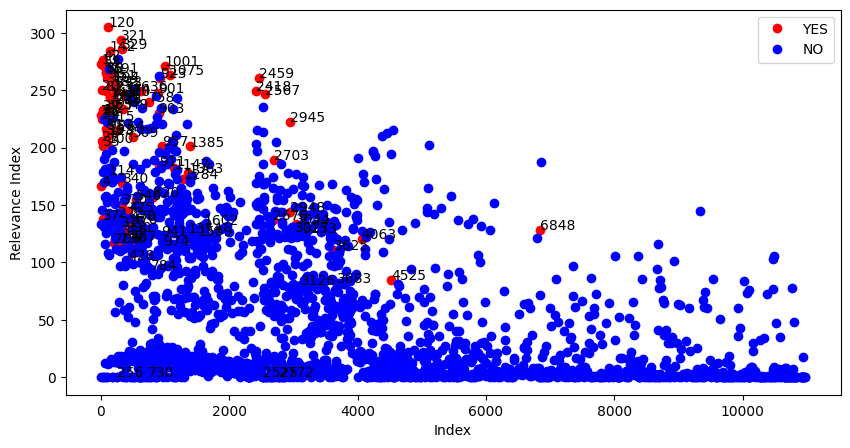

In [30]:
# plot the dot plot of the relevance_index of YESs and NOs of the test data set
plt.figure(figsize=(10, 5))
plt.plot(R_index_list, R_relevance_index_list, 'ro', label="YES")
plt.plot(IR_index_list, IR_relevance_index_list, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Relevance Index")
plt.legend()

# add labels for the relevant index points
for i, index in enumerate(R_index_list):
    plt.text(index, R_relevance_index_list[i]+0.1, str(index), color='black', fontsize=10)

# # add labels for the relevant index points
# for i, index in enumerate(IR_index_list):
#     plt.text(index, IR_relevance_index_list[i], str(index), color='black', fontsize=10)

# plt.text(37, IR_relevance_index_list[IR_index_list.index(37)], str(37), color='black', fontsize=10)
# plt.text(3683, R_relevance_index_list[R_index_list.index(3683)], str(3683), color='black', fontsize=10)
plt.show()

In [31]:
# min_relevance_index_index = 4525
min_relevance_index_index = R_index_list[R_relevance_index_list.index(min(x for x in R_relevance_index_list if x != 0))]
print(min_relevance_index_index)

# for i in range(len(relvant_index_list)):
#     print(relvant_index_list[i], relevant_relevance_index_list[i])
# print(relevant_relevance_index_list)

for ind in df_db_ranked.index:
    if df_db_ranked.at[ind, "INDEX"] == min_relevance_index_index:
        min_relevance_index_ind = ind
        break 

min_relev_index_num = min_relevance_index_ind  + 1
num = math.ceil(min_relev_index_num * 1.3)
threshold_index = df_db_ranked.at[num-1, 'INDEX']

print(f"The index with the minimum relevance index: {min_relevance_index_index}")
print(f"The number of articles with relevance index larger or equal than that of {min_relevance_index_index}: {min_relev_index_num}")
print(f"The index of the article with the threshold relevance index: {threshold_index}")
print(f"The number of articles to manually check is {num}")
print(f"The threshold index is {threshold_index}")

3126
The index with the minimum relevance index: 3126
The number of articles with relevance index larger or equal than that of 3126: 1574
The index of the article with the threshold relevance index: 1467
The number of articles to manually check is 2047
The threshold index is 1467


In [32]:
def pick_values_uniformly(data, n):
    """Pick up `n` values uniformly from `data`."""
    if n < 1:
        return []

    # Determine the range of the data
    min_val, max_val = min(data), max(data)

    threshold = (max_val - min_val) / n / 2

    # If n is 1, just return the midpoint
    if n == 1:
        return [(min_val + max_val) / 2]

    # Calculate the interval size
    interval = (max_val - min_val) / (n - 1)

    # Get the uniform values
    return [min_val + i * interval for i in range(n)], threshold

# data = [1, 3, 5, 2, 8, 10, 2]
n = 5
density_display_index, thres = pick_values_uniformly(R_relevance_index_list + IR_relevance_index_list, n)
# print(density_display_index)

Numer of relevant literature: 101
Number of not relevant literature: 2061



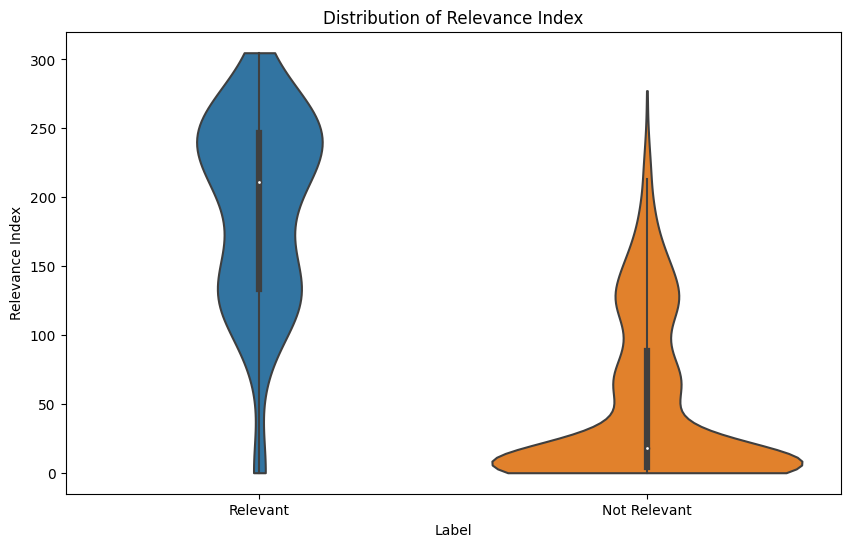

In [33]:
# visualize the distribution of the relevance group and the non-relevance group as violin plots

# Printing the length of lists
print("Numer of relevant literature:", len(R_relevance_index_list))
print("Number of not relevant literature:", len(IR_relevance_index_list))
print()

# Create a DataFrame for plotting
df = pd.DataFrame({'Relevance Index': R_relevance_index_list + IR_relevance_index_list, 
                   'Label': ['Relevant'] * len(R_relevance_index_list) + ['Not Relevant'] * len(IR_relevance_index_list)})

# Draw the violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='Label', y='Relevance Index', data=df, bw='scott', cut=0)

# relevance_indices = density_display_index  # Replace with your relevance indices

# threshold = thres  # Adjust this based on your desired range around the relevance index

# for index in relevance_indices:
#     ax.axhline(index, color='gray', linestyle='--')
    
#     for i, label in enumerate(df['Label'].unique()):
#         # Filter data points close to the current relevance index
#         close_points = df[(df['Label'] == label) & (np.abs(df['Relevance Index'] - index) < threshold)]
#         density = len(close_points)
        
#         ax.text(i, index + 0.1, str(density), ha='center', va='center', color='red', fontsize=9)  # adjust the vertical offset (0.1 here) as necessary

plt.title('Distribution of Relevance Index')
plt.show()

In [34]:
# Check the equality of variances
var_relevant = np.var(R_relevance_index_list)
var_non_relevant = np.var(IR_relevance_index_list)
print('Variance of RELEVANCE_INDEX of the relevant group:', var_relevant)
print('Variance of RELEVANCE_INDEX of the non-relevant group:', var_non_relevant)
print('Ratio of the above variance:', var_relevant/var_non_relevant)

Variance of RELEVANCE_INDEX of the relevant group: 4838.537062453782
Variance of RELEVANCE_INDEX of the non-relevant group: 3488.2604442641536
Ratio of the above variance: 1.3870916864622098


### 3. Prepare the final list of articles to manually read

In [35]:
# Read the DataFrame from a CSV file
df = pd.read_csv(fpath.poten_litera_db_ranked_by_ta, header=0, sep='\t')  # Replace with your CSV file path

index_above_threshold = []
index_below_threshold = []

# flag of being relevant
flag = True
# Iterate through the DataFrame and add the index to the list
for ind, row in df.iterrows():
    index = int(row['INDEX'])
    
    if not flag and (index == threshold_index):
        raise Exception("The index of the article with the threshold relevance index is not unique!")
    
    if index == threshold_index:
        index_above_threshold.append(index)
        flag = False
    else: 
        if flag:
            index_above_threshold.append(index)
        else:
            index_below_threshold.append(index)
    
print(len(index_above_threshold))
print(len(index_below_threshold))

print(index_above_threshold)
print(index_below_threshold)

2047
8729
[120, 321, 329, 142, 277, 42, 11, 53, 1001, 126, 89, 76, 191, 1075, 904, 96, 923, 2459, 416, 151, 194, 242, 182, 531, 20, 636, 232, 82, 2418, 901, 374, 2567, 438, 380, 867, 143, 1193, 147, 185, 517, 758, 228, 218, 2535, 945, 637, 1134, 349, 127, 39, 92, 903, 23, 7, 41, 17, 878, 196, 57, 29, 115, 97, 586, 2945, 433, 1033, 868, 952, 1341, 927, 785, 721, 631, 81, 95, 2428, 4545, 264, 2521, 1042, 50, 4457, 739, 103, 128, 28, 1173, 4378, 686, 509, 1221, 335, 245, 27, 248, 1108, 2735, 4038, 100, 67, 405, 101, 2414, 650, 899, 360, 44, 122, 5114, 1109, 957, 33, 47, 1385, 90, 2586, 1059, 1307, 648, 916, 931, 1131, 439, 171, 365, 841, 1166, 236, 4242, 2438, 473, 3599, 124, 4240, 752, 48, 912, 105, 13, 1236, 198, 4524, 83, 1002, 8, 4003, 4267, 161, 91, 687, 166, 4011, 275, 56, 1302, 1090, 211, 203, 162, 2464, 2703, 1061, 835, 276, 914, 1642, 98, 6856, 257, 210, 529, 706, 383, 1041, 2786, 222, 2812, 935, 501, 246, 1693, 2528, 500, 15, 960, 1337, 911, 34, 337, 45, 1557, 1845, 946, 732, 13

In [36]:
# # add the index of the articles with 'inject' in the full text and articles without full text
# articles_with_keyword = []
# articles_short = []
# articles_without_full_text = []

# for article_index in index_below_threshold:
#     full_text_file_path = os.path.join(fpath.text_folder, str(article_index)+'.txt')
    
#     # if the full text file exists
#     if os.path.exists(full_text_file_path):
#         with open(full_text_file_path, 'r', encoding='ascii') as file:
#             # Read the contents of the file
#             text = file.read()
#         text = plib.process_text(text, lower=True)
        
#         species = False
#         inject = False
#         thalam = False
        
#         for word in ['rhesus', 'macaque', 'macaca']:
#             if word in text:
#                 species = True
        
#         if 'inject' in text:
#             inject = True
            
#         if 'thalam' in text:
#             thalam = True
            
#         if species and inject and thalam and len(text.split()) >= 3000:
#             articles_with_keyword.append(article_index)
#         if len(text.split()) < 3000:
#             articles_short.append(article_index)
#     else:
#         articles_without_full_text.append(article_index)

# print(len(articles_with_keyword))
# print(len(articles_short))
# print(len(articles_without_full_text))
# print(articles_with_keyword)
# print(articles_short)
# print(articles_without_full_text)

Only the articels above the threshold index, articles with short text and articles with no text are included.

In [37]:
# index_above_threshold = index_above_threshold + articles_short + articles_without_full_text
# print(len(index_above_threshold))

In [38]:
# save the index_above_threshold
with open(fpath.article_list_to_manually_read, 'w') as file:
    # Convert each number to string and join them with commas
    numbers_str = ','.join(map(str, index_above_threshold))
    
    # Write the string to the file
    file.write(numbers_str)

In [39]:
# save the R_review_index_list
with open(fpath.relevant_article_and_is_review, 'w') as file:
    # Convert each number to string and join them with commas
    numbers_str = ','.join(map(str, R_review_index_list))
    
    # Write the string to the file
    file.write(numbers_str)

<h3> Next step: manually read papers and find all actually related literature </h3>